This file contains tuning of Random Forest Classifier using optuna as well as the comparison with the baseline model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import random
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/PG32 CS3244/smoteNCTrain.csv')
df_test = pd.read_csv('/content/drive/MyDrive/PG32 CS3244/smoteNCTest.csv')

In [ ]:
df_train.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,STATUS
0,0,0,0,0,135000.0,4,1,1,4,-13566,-1900,1,6,2,0
1,1,1,1,0,315000.0,4,3,3,4,-10328,-543,0,6,1,0
2,0,1,1,0,315000.0,0,1,2,4,-18184,-3021,0,8,1,0
3,0,0,1,1,180000.0,2,1,3,4,-13467,-3850,0,11,2,0
4,1,1,0,1,247500.0,4,1,1,4,-13086,-1931,0,8,3,0


In [ ]:
df_test.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_WORK_PHONE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,STATUS
0,0,0,1,0,202500.0,2,1,2,4,-16834,-1692,0,11,1,0
1,1,1,0,0,675000.0,0,3,1,4,-18126,-948,0,10,2,0
2,0,0,0,0,234000.0,2,3,0,4,-21967,-5215,0,3,2,0
3,0,1,1,0,445500.0,0,3,1,4,-12477,-456,0,10,2,0
4,0,1,0,0,225000.0,4,1,1,5,-12155,-667,0,8,2,0


In [ ]:
df_train.shape

(50164, 15)

In [ ]:
df_test.shape

(21518, 15)

In [ ]:
X_train = df_train.iloc[:,1:-1] # all the variables
y_train = df_train.iloc[:,-1] # labels

X_test = df_test.iloc[:,1:-1] # all the variables
y_test = df_test.iloc[:,-1] # labels

In [ ]:
### Helper method

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Baseline of the model

--------RF Baseline--------
14677
Accuracy Score is 0.68208
Recall Score is 0.37754
Precision Score is 0.96576
F1 Score is 0.54287
       0     1
0  10615   144
1   6697  4062
[[0.98661586 0.01338414]
 [0.62245562 0.37754438]]


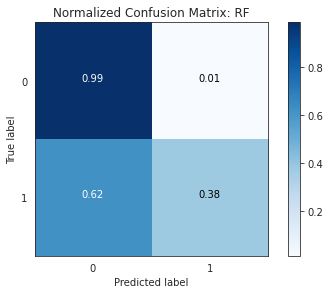

In [ ]:
print("--------RF Baseline--------")

model = RandomForestClassifier(random_state = 42)
model.fit(X_train, y_train)

y_predict = model.predict(X_test)
print(sum(y_predict == y_test))
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print('Recall Score is {:.5}'.format(recall_score(y_test, y_predict)))
print('Precision Score is {:.5}'.format(precision_score(y_test, y_predict)))
print('F1 Score is {:.5}'.format(f1_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: RF')

#### Model Tuning: Random Forest with Optuna

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 5.2 MB/s 
     |████████████████████████████████| 81 kB 7.5 MB/s 
     |████████████████████████████████| 209 kB 46.6 MB/s 
     |████████████████████████████████| 78 kB 6.4 MB/s 
     |████████████████████████████████| 147 kB 57.4 MB/s 
     |████████████████████████████████| 50 kB 5.9 MB/s 
     |████████████████████████████████| 112 kB 54.6 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=68d06fa694ba41d8d5819b49f733d05d87d6b08ac06badb3ba51b27319fc0437
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
from sklearn.model_selection import cross_val_score
import optuna
def objective(trial):
  params_grid = {
      "n_estimators" : trial.suggest_int("n_estimator", 100),
      "max_depth" : trial.suggest_int("max_depth", 5, 50),
      "min_samples_split": trial.suggest_int("min_sample_split", 2, 15),
      "min_samples_leaf": trial.suggest_int("min_sample_leaf", 1, 60),
      "max_features": trial.suggest_categorical("max_festures", ["auto", "sqrt"])
  }
  model = RandomForestClassifier(random_state = 42, **params_grid)
  score = cross_val_score(model, X_train, y_train, cv = 5).mean()
  return score

In [ ]:
study = optuna.create_study(direction = "maximize")
study.optimize(objective, n_trials = 60)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}= {}, ".format(key, value))

[I 2022-11-02 11:50:07,922] A new study created in memory with name: no-name-0009ed0d-8b83-4ee5-b243-d263d9ab494b
[I 2022-11-02 11:51:03,044] Trial 0 finished with value: 0.8416795825768585 and parameters: {'n_estimator': 307, 'max_depth': 10, 'min_sample_split': 5, 'min_sample_leaf': 18, 'max_festures': 'sqrt'}. Best is trial 0 with value: 0.8416795825768585.
[I 2022-11-02 11:51:51,055] Trial 1 finished with value: 0.6582211417632816 and parameters: {'n_estimator': 480, 'max_depth': 4, 'min_sample_split': 8, 'min_sample_leaf': 55, 'max_festures': 'sqrt'}. Best is trial 0 with value: 0.8416795825768585.
[I 2022-11-02 11:52:34,255] Trial 2 finished with value: 0.8610958657006043 and parameters: {'n_estimator': 240, 'max_depth': 11, 'min_sample_split': 8, 'min_sample_leaf': 19, 'max_festures': 'sqrt'}. Best is trial 2 with value: 0.8610958657006043.
[I 2022-11-02 11:53:35,308] Trial 3 finished with value: 0.7094931045730906 and parameters: {'n_estimator': 497, 'max_depth': 6, 'min_sample

Best Score:  0.9064669107892916
Best Params: 
  n_estimator= 352, 
  max_depth= 13, 
  min_sample_split= 11, 
  min_sample_leaf= 9, 
  max_festures= auto, 


Results from Optuna:

Best Params: 
  n_estimator= 352, 
  max_depth= 13, 
  min_sample_split= 11, 
  min_sample_leaf= 9, 
  max_festures= auto,

Compared with the base model, there's a 0.03 increase in accuracy, 0.2 increase in recall, 0.16 decrease in accuracy, and 0.13 increase in F1 Score.

--------RF Better?--------
15449
Accuracy Score is 0.71796
Recall Score is 0.5797
Precision Score is 0.80126
F1 Score is 0.67271
      0     1
0  9212  1547
1  4522  6237
[[0.8562134  0.1437866 ]
 [0.42029928 0.57970072]]


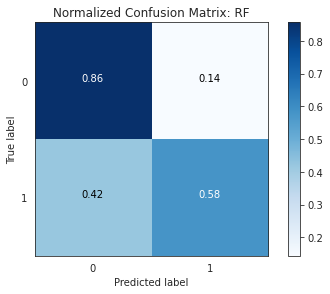

In [ ]:
print("--------RF Better?--------")
model = RandomForestClassifier(random_state = 42,
  criterion= "gini", 
  n_estimators= 352, 
  max_depth= 13,
  min_samples_split= 11, 
  min_samples_leaf= 9,  
  max_features= "auto")
model.fit(X_train, y_train)

y_predict = model.predict(X_test)
print(sum(y_predict == y_test))
print('Accuracy Score is {:.5}'.format(accuracy_score(y_test, y_predict)))
print('Recall Score is {:.5}'.format(recall_score(y_test, y_predict)))
print('Precision Score is {:.5}'.format(precision_score(y_test, y_predict)))
print('F1 Score is {:.5}'.format(f1_score(y_test, y_predict)))
print(pd.DataFrame(confusion_matrix(y_test,y_predict)))


sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test,y_predict),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix: RF')

In [ ]:
optuna.visualization.plot_param_importances(study)

We can see from the above graph that max_depth is the determining factor as a high max_depth might overfit the data.